# Time Series Analysis

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Loading packages
# Basic + dates
import numpy as np
import pandas as pd
# from datetime import datetime

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from statsmodels.distributions.empirical_distribution import ECDF

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Simple verification
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("statsmodels version:", ECDF.__module__.split('.')[0])

numpy version: 1.26.4
pandas version: 2.2.2
seaborn version: 0.13.2
statsmodels version: statsmodels


In [9]:
# importing train data to learn
train = pd.read_csv("../data/raw/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("../data/raw/store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

## Exploratory Data Analysis 

In this first section we go through the train and store data, handle missing values and create new features for further analysis.

In [10]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5)

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


##### Short description:
- Sales: the turnover for any given day (target variable).
- Customers: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

In [13]:
import pandas as pd

# Assuming 'train' is your DataFrame and its index is a DatetimeIndex
# Here is an example of setting up a sample DataFrame with a DatetimeIndex
# You can skip this part if your DataFrame 'train' is already defined
# dates = pd.date_range(start='2021-01-01', periods=10, freq='D')
# data = {'Sales': range(10), 'Customers': range(10, 20)}
# train = pd.DataFrame(data, index=dates)

# Ensure that the index is a DatetimeIndex
if not isinstance(train.index, pd.DatetimeIndex):
    train.index = pd.to_datetime(train.index)

# Extracting month and day from the index
train['Month'] = train.index.month
train['Day'] = train.index.day

# Extracting week of the year using isocalendar()
train['WeekOfYear'] = train.index.isocalendar().week

# Adding a new variable
train['SalePerCustomer'] = train['Sales'] / train['Customers']

# Print the resulting DataFrame for debugging
print(train)

# Debugging outputs to understand the transformations
print(f"Months: {train['Month'].head()}")
print(f"Days: {train['Day'].head()}")
print(f"Weeks of the Year: {train['WeekOfYear'].head()}")
print(f"Sales Per Customer: {train['SalePerCustomer'].head()}")


            Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   
...           ...        ...    ...        ...   ...    ...          ...   
2013-01-01   1111          2      0          0     0      0            a   
2013-01-01   1112          2      0          0     0      0            a   
2013-01-01   1113          2      0          0     0      0            a   
2013-01-01   1114          2      0          0     0      0            a   
2013-01-01   1115          2      0          0     0      0            a   

           

##### On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.

#### ECDF: empirical cumulative distribution function

##### To get the first impression about continious variables in the data we can plot ECDF.

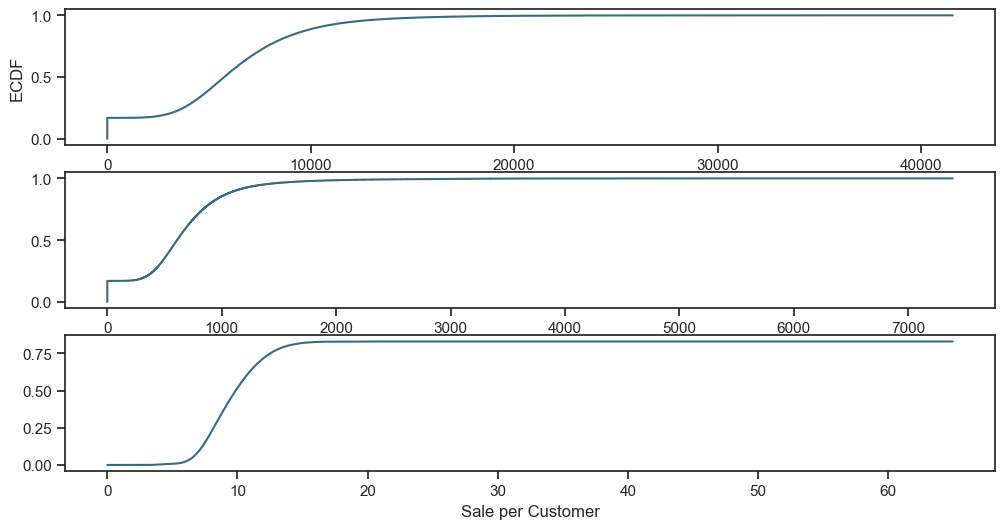

In [15]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

#### Closed stores and zero sales stores

In [16]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values. 

What about opened stores with zero sales?

In [17]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


Interestingly enough, there are opened store with __no sales on working days__. There're only 54 days in the data, so we can assume that there were external factors involved, for example manifestations.

In [18]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


What about store information:

In [19]:
# additional information about the stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [20]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We have few variables with missing values that we need to deal with. Let's start with the `CompetitionDistance`.

In [21]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Apperently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average).

In [22]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

Continuing further with missing data. What about `Promo2SinceWeek`? May it be that we observe unsusual data points?

In [23]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

No, if there's no `Promo2` then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`.

In [24]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [25]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


### Store types

In this section we will closely look at different levels of `StoreType` and how the main metric `Sales` is distributed among them.  

In [29]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


`StoreType` B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of `Sales` and `Customers` to see which `StoreType` is the most selling and crowded one:

In [31]:
# Grouping by 'StoreType' and summing 'Customers' and 'Sales'
grouped_data = train_store.groupby('StoreType')[['Customers', 'Sales']].sum()

# Print the resulting DataFrame for debugging
print(grouped_data)

           Customers       Sales
StoreType                       
a          363541431  3165334859
b           31465616   159231395
c           92129705   783221426
d          156904995  1765392943


Clearly stores of type A. `StoreType` D goes on the second place in both `Sales` and `Customers`.
What about date periods? Seaborn's facet grid is the best tool for this task:

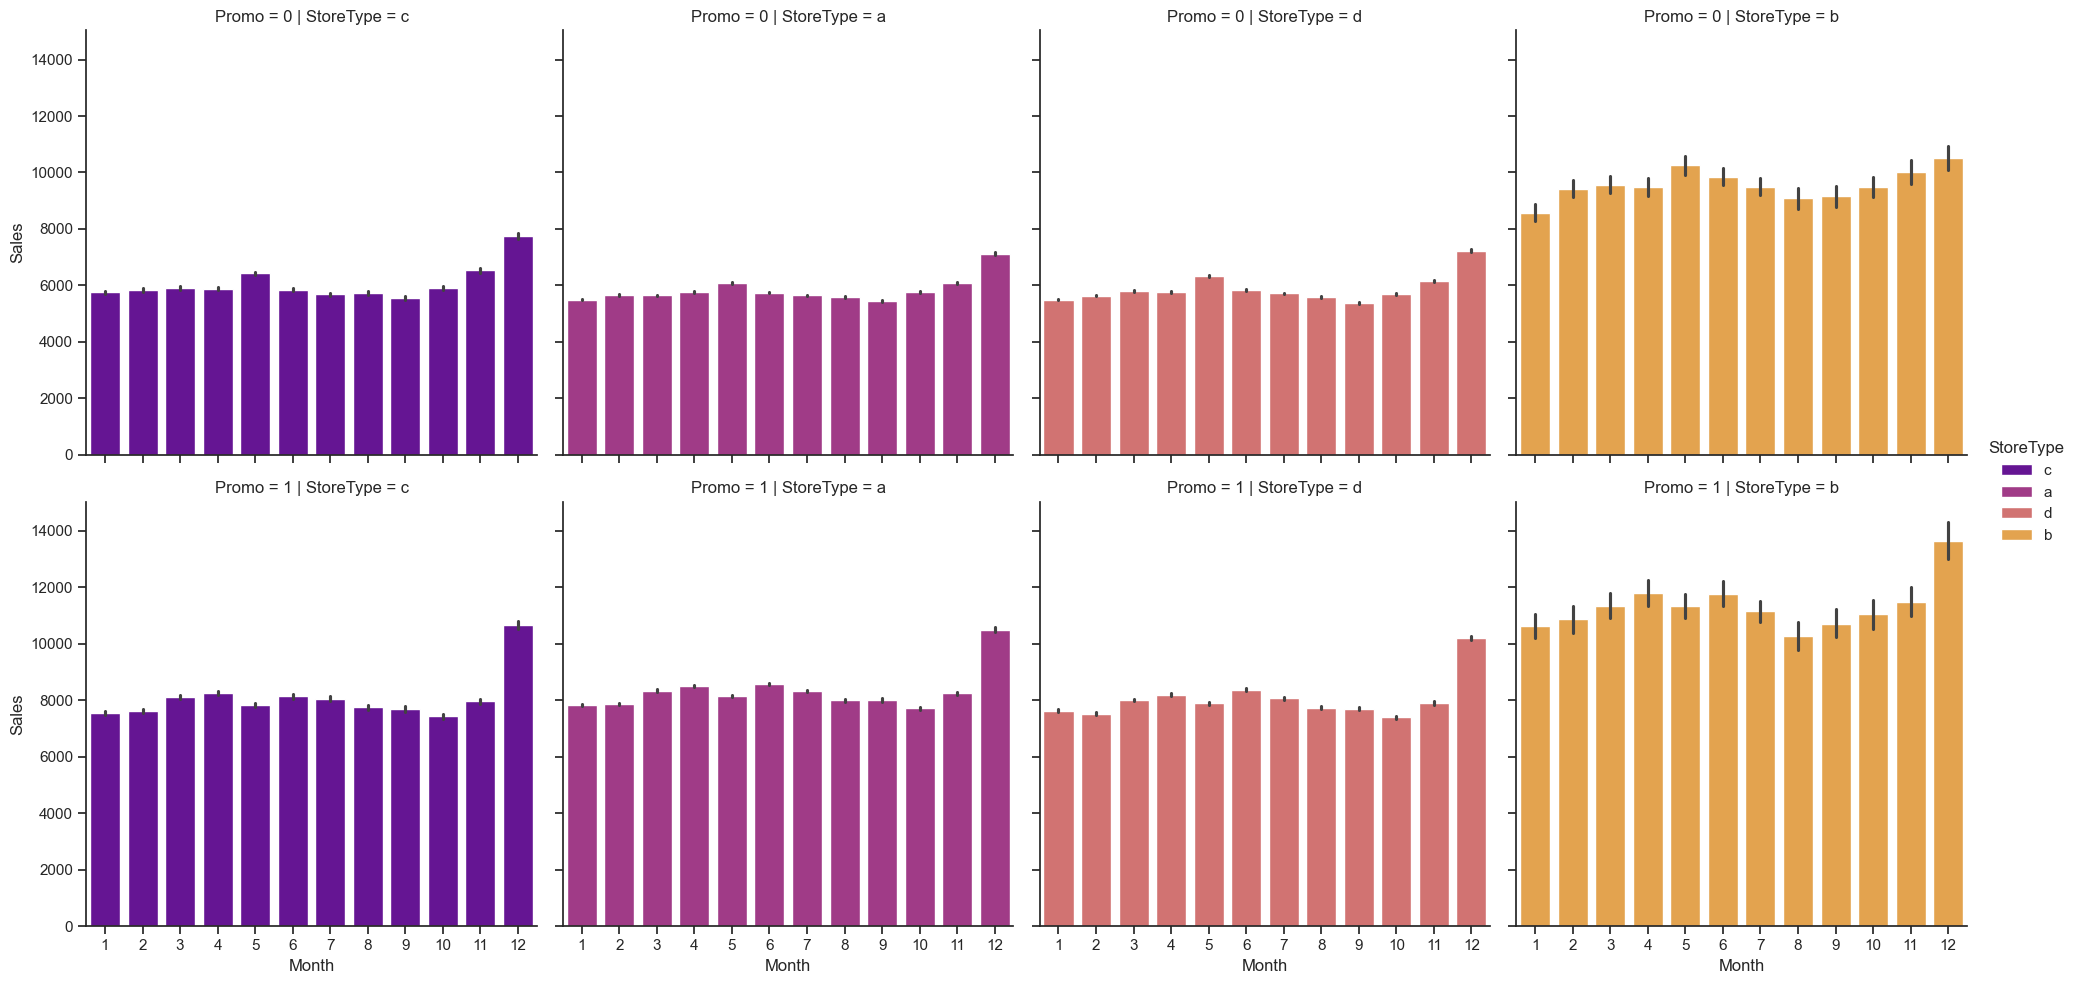

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_store' is your DataFrame
# Here is an example of setting up a sample DataFrame
# You can skip this part if your DataFrame 'train_store' is already defined
# data = {
#     'Month': [1, 1, 2, 2, 3, 3, 4, 4],
#     'Sales': [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500],
#     'StoreType': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'B'],
#     'Promo': [1, 0, 1, 0, 1, 0, 1, 0]
# }
# train_store = pd.DataFrame(data)

# Set color for the plot
c = "plasma"

# Plotting sales trends using catplot
sns.catplot(
    data=train_store, 
    x='Month', 
    y='Sales', 
    col='StoreType',  # per store type in columns
    palette=c, 
    hue='StoreType', 
    row='Promo',  # per promo in the store in rows
    kind='bar'  # specify the kind of plot, here using 'bar' as an example
)

# Show plot
plt.show()

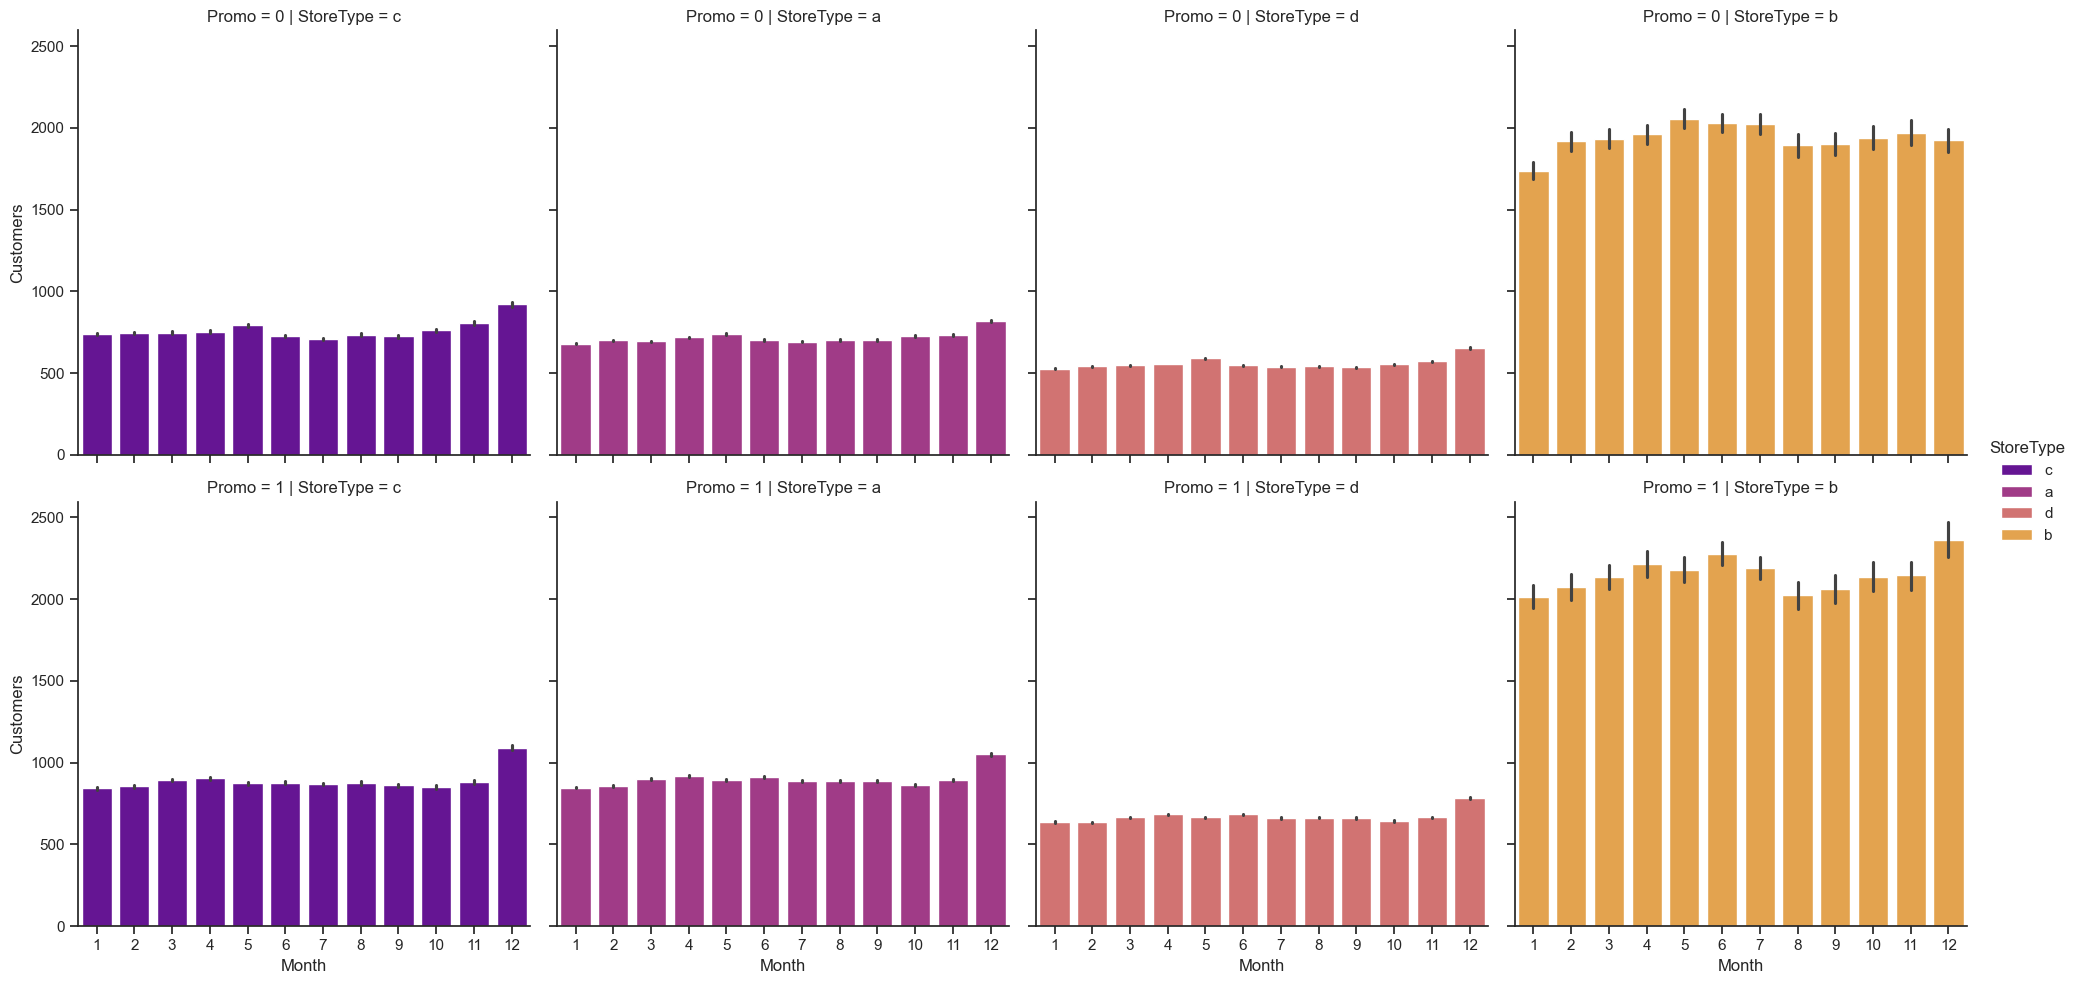

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_store' is your DataFrame
# Here is an example of setting up a sample DataFrame
# You can skip this part if your DataFrame 'train_store' is already defined
# data = {
#     'Month': [1, 1, 2, 2, 3, 3, 4, 4],
#     'Customers': [100, 150, 200, 250, 300, 350, 400, 450],
#     'StoreType': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'B'],
#     'Promo': [1, 0, 1, 0, 1, 0, 1, 0]
# }
# train_store = pd.DataFrame(data)

# Set color palette for the plot
c = "plasma"

# Plotting sales trends using catplot
sns.catplot(
    data=train_store, 
    x='Month', 
    y='Customers', 
    col='StoreType',  # per store type in columns
    palette=c, 
    hue='StoreType', 
    row='Promo',  # per promo in the store in rows
    kind='bar'  # specify the kind of plot, here using 'bar' as an example
)

# Show plot
plt.show()

All store types follow the same trend but at different scales depending on the presence of the (first) promotion `Promo` and `StoreType` itself (case for B).

__Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.__

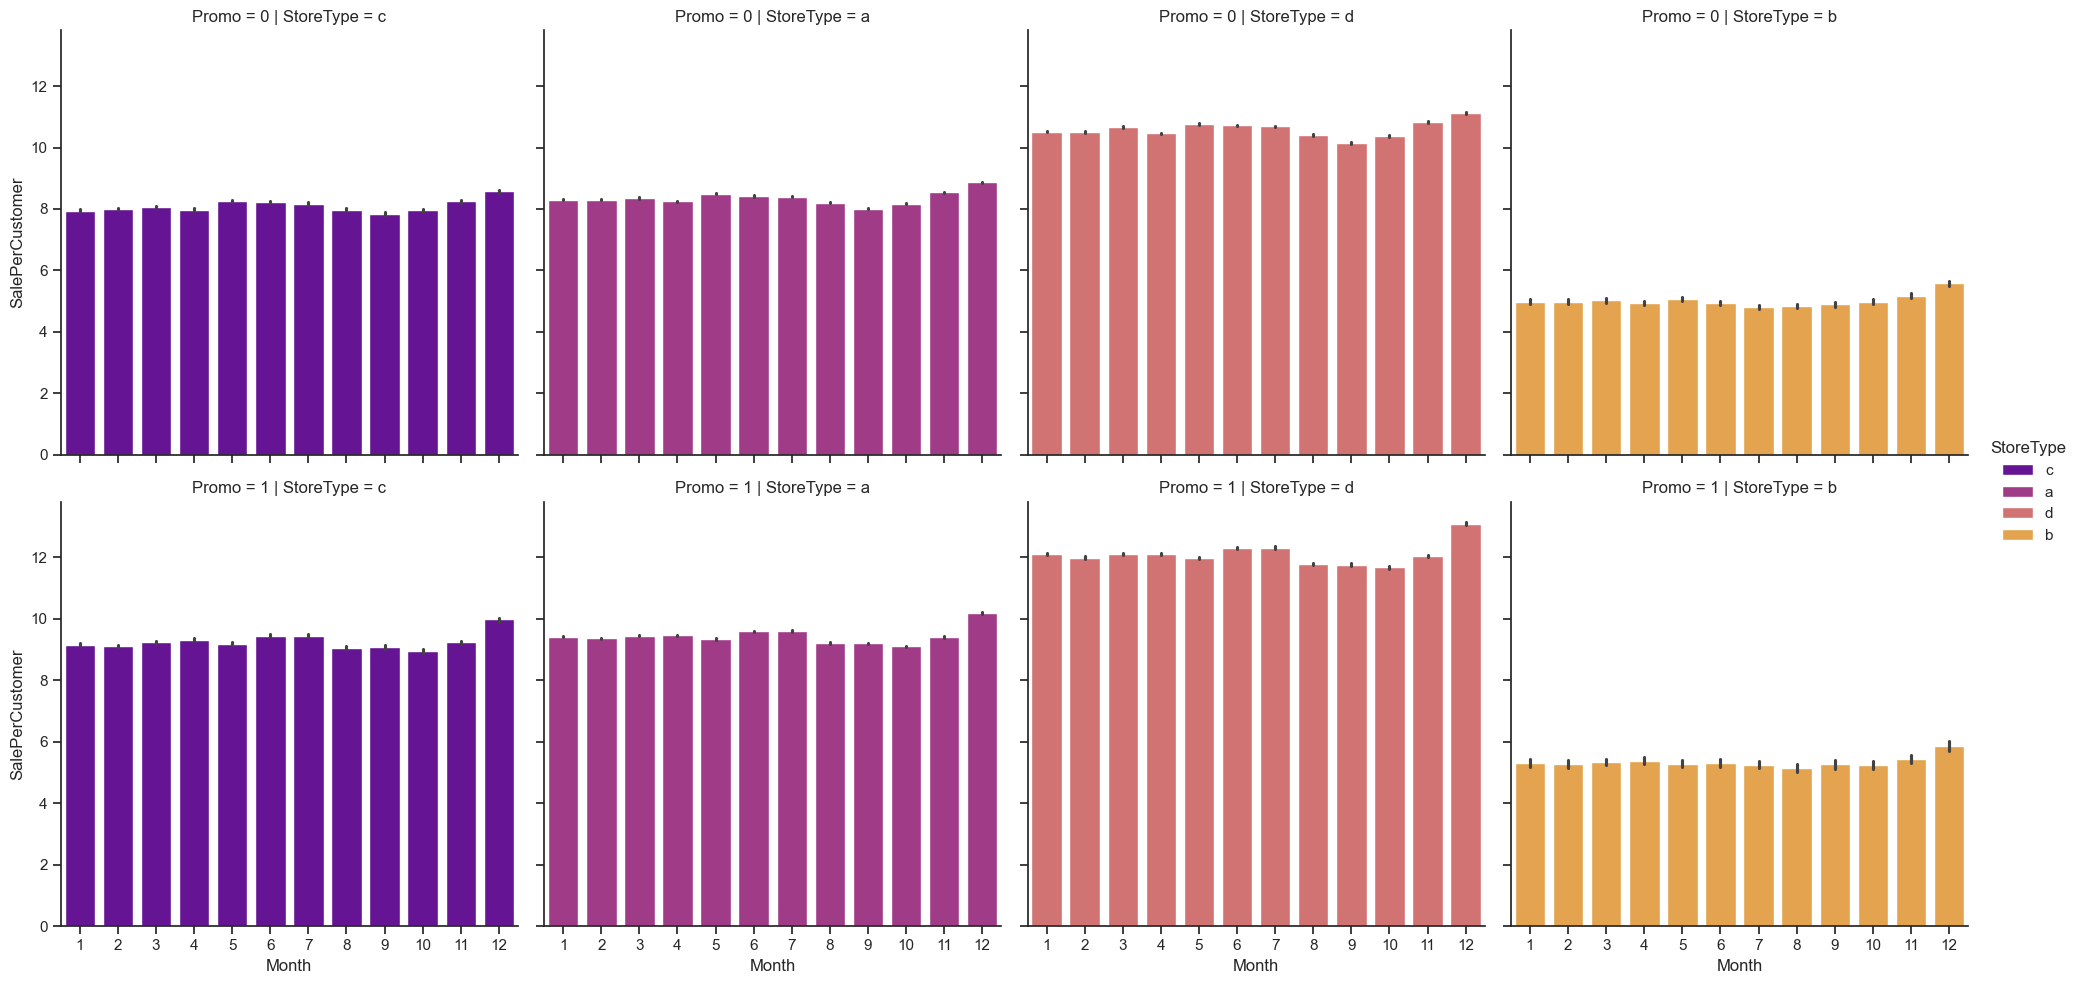

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_store' is your DataFrame and it includes the 'SalePerCustomer' column
# Example setup for 'train_store' DataFrame
# You can skip this part if your DataFrame 'train_store' is already defined
# data = {
#     'Month': [1, 1, 2, 2, 3, 3, 4, 4],
#     'SalePerCustomer': [10, 15, 20, 25, 30, 35, 40, 45],
#     'StoreType': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'B'],
#     'Promo': [1, 0, 1, 0, 1, 0, 1, 0]
# }
# train_store = pd.DataFrame(data)

# Set color palette for the plot
c = "plasma"

# Plotting sale per customer trends using catplot
sns.catplot(
    data=train_store, 
    x='Month', 
    y='SalePerCustomer', 
    col='StoreType',  # per store type in columns
    palette=c, 
    hue='StoreType', 
    row='Promo',  # per promo in the store in rows
    kind='bar'  # specify the kind of plot, here using 'bar' as an example
)

# Show plot
plt.show()

Aha! Eventhough the plots above showed `StoreType` B as the most selling and performant one, in reality it is not true. The highest `SalePerCustomer` amount is observed at the `StoreType` D, about 12€ with `Promo` and 10€ without. As for `StoreType` A and C it is about 9€. 

Low `SalePerCustomer` amount for `StoreType` B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this `StoreType` generated the least amount of sales and customers over the period.

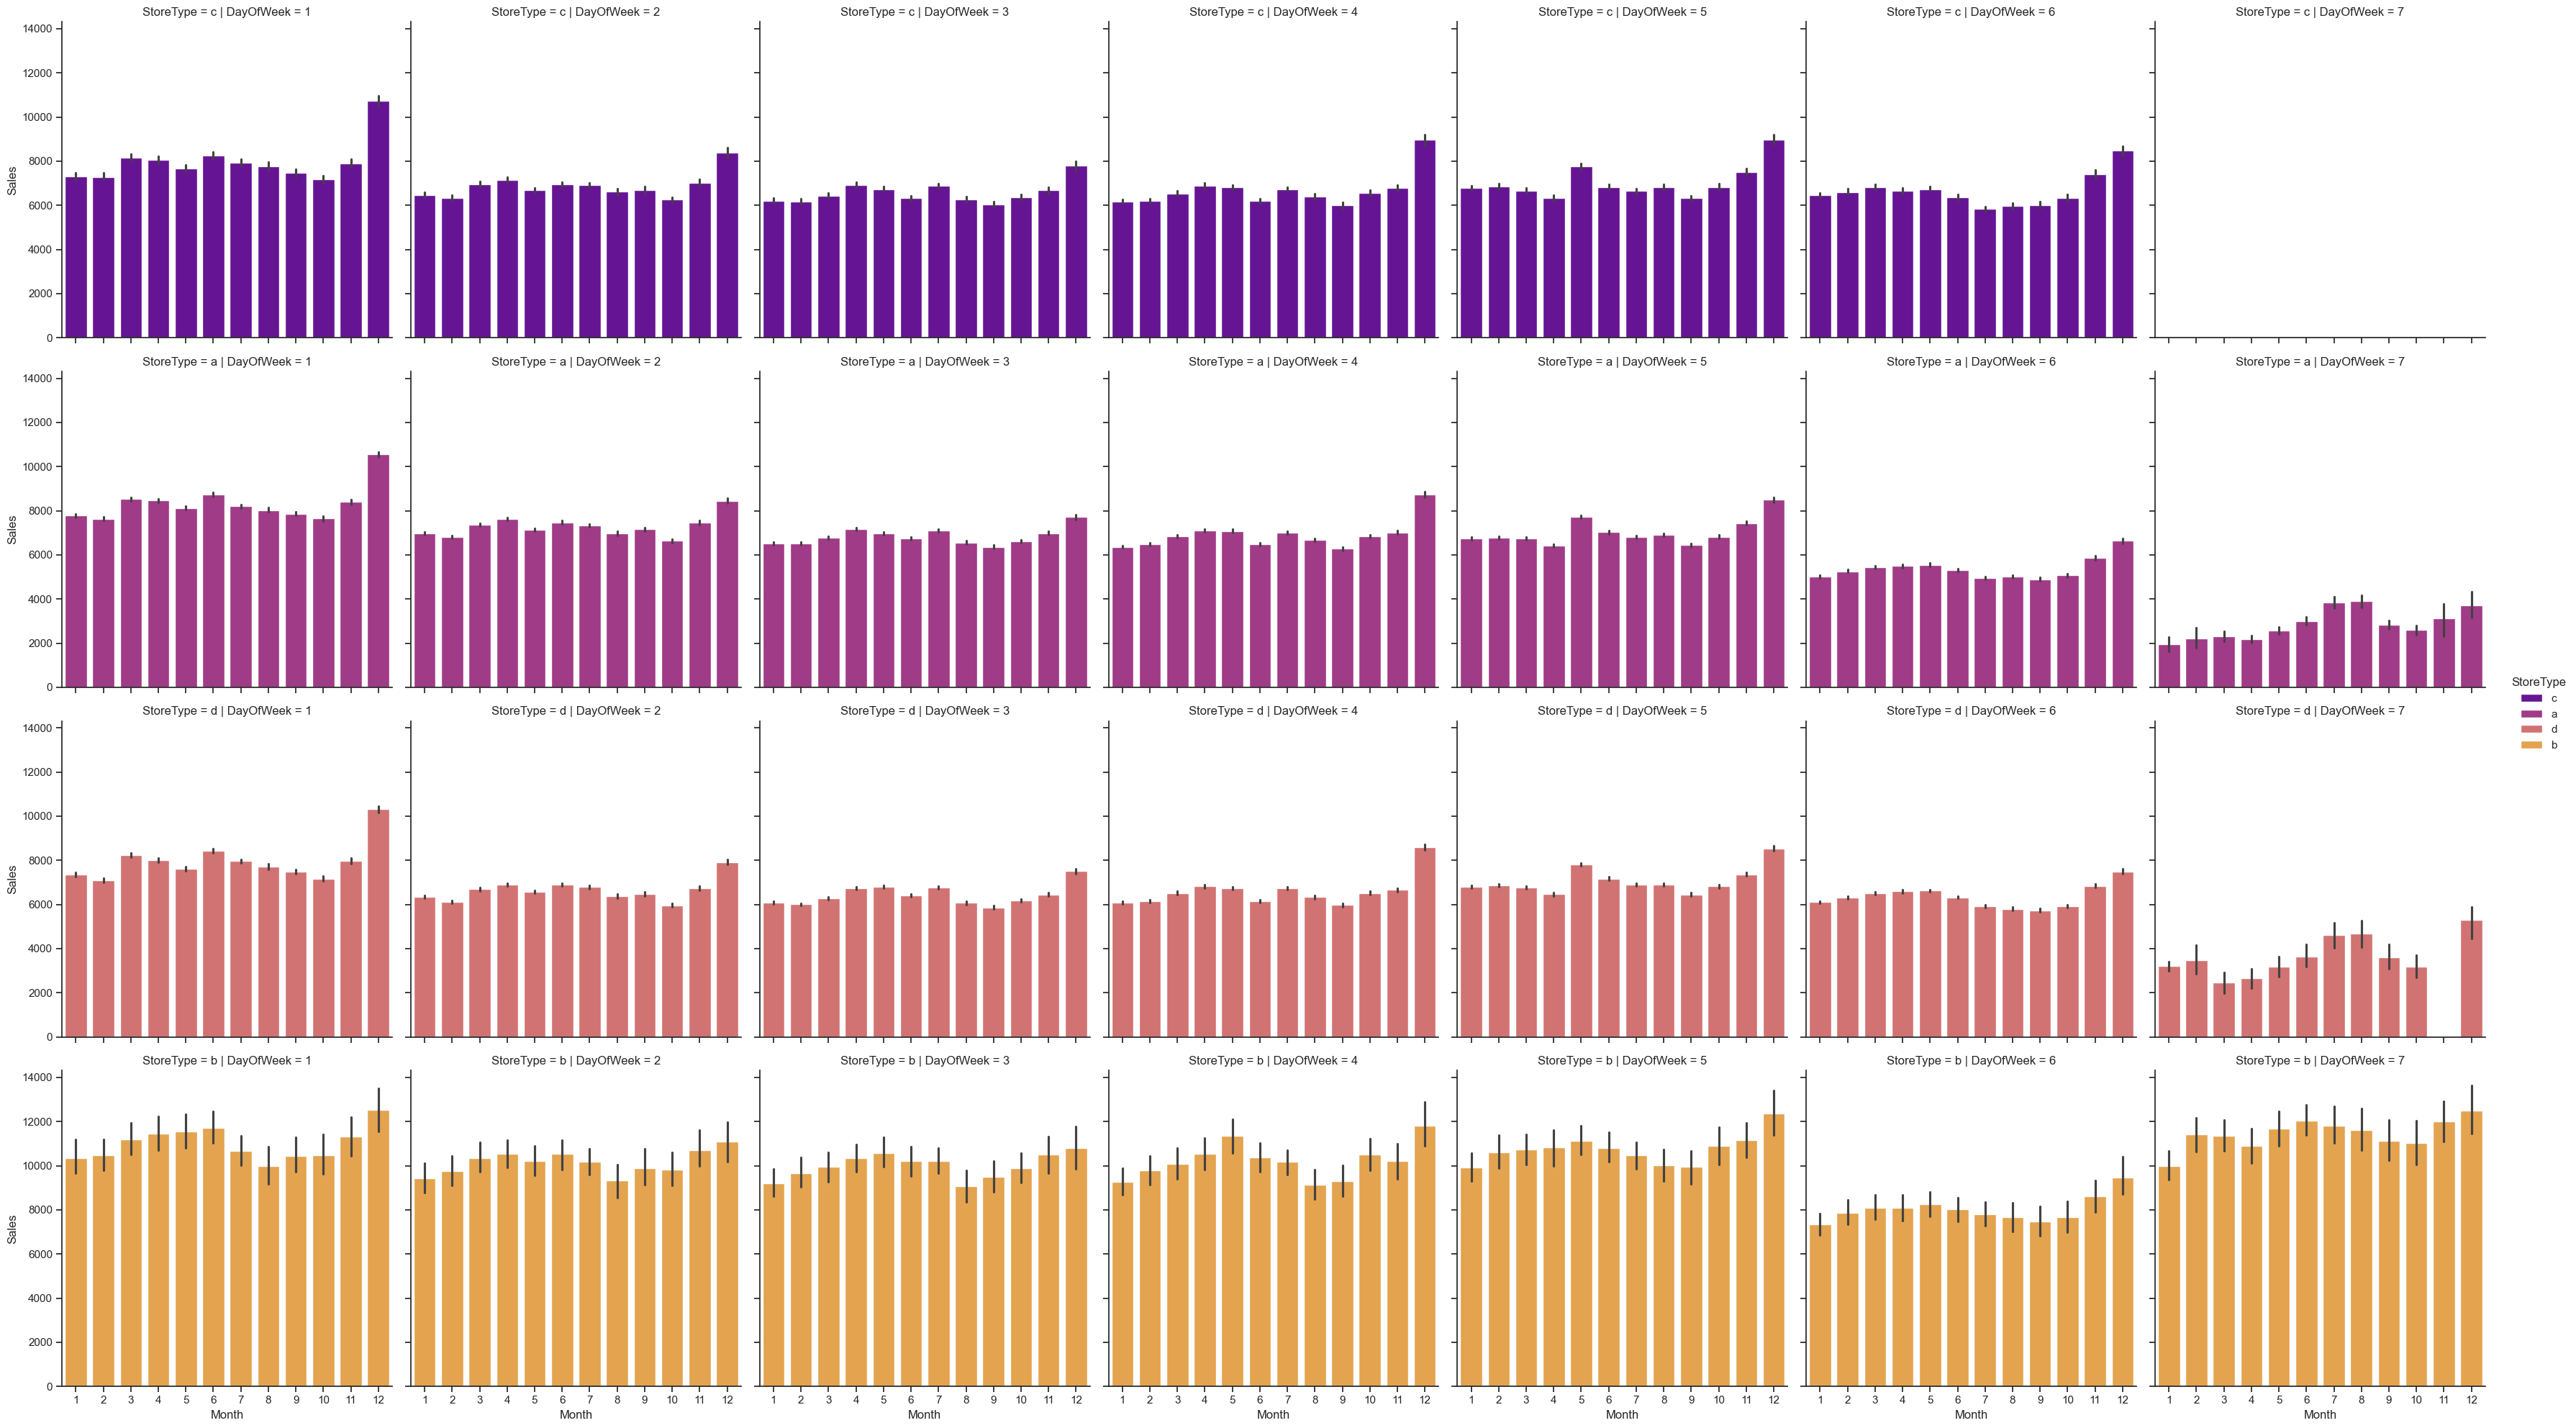

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_store' is your DataFrame and it includes the relevant columns
# Example setup for 'train_store' DataFrame
# You can skip this part if your DataFrame 'train_store' is already defined
# data = {
#     'Month': [1, 1, 2, 2, 3, 3, 4, 4],
#     'Sales': [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500],
#     'DayOfWeek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon'],
#     'StoreType': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'B']
# }
# train_store = pd.DataFrame(data)

# Set color palette for the plot
c = "plasma"

# Plotting sales data using catplot
sns.catplot(
    data=train_store, 
    x='Month', 
    y='Sales', 
    col='DayOfWeek',  # per day of the week in columns
    palette=c, 
    hue='StoreType', 
    row='StoreType',  # per store type in rows
    kind='bar'  # specify the kind of plot, here using 'bar' as an example
)

# Show plot
plt.show()

We see that stores of `StoreType` C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of `StoreType` D are closed on Sundays only from October to December.

Bt the way what are the stores which are opened on Sundays?

In [40]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877],
      dtype=int64)

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [41]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


The most selling and crowded `StoreType` A doesn't appear to be the one the most exposed to competitors. Instead it's a `StoreType` B, which also has the longest running period of promotion.

### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the `seaborn` heatmap:

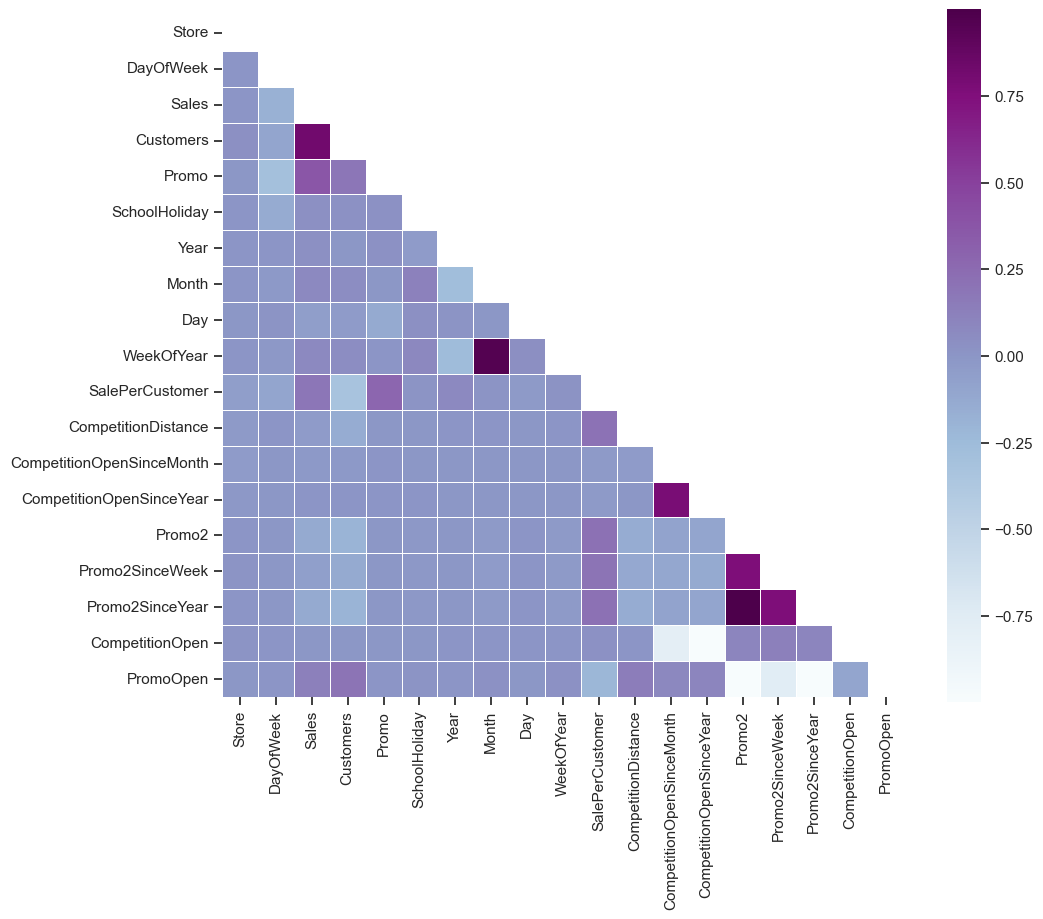

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix excluding non-numeric columns and the 'Open' variable
numeric_cols = train_store.drop('Open', axis=1).select_dtypes(include=[np.number])
corr_all = numeric_cols.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask=mask,
            square=True, linewidths=.5, ax=ax, cmap="BuPu")

# Show plot
plt.show()

As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (`Promo` equal to 1) and amount of `Customers`. 

However, as soon as the store continues a consecutive promotion (`Promo2` equal to 1) the number of `Customers` and `Sales` seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

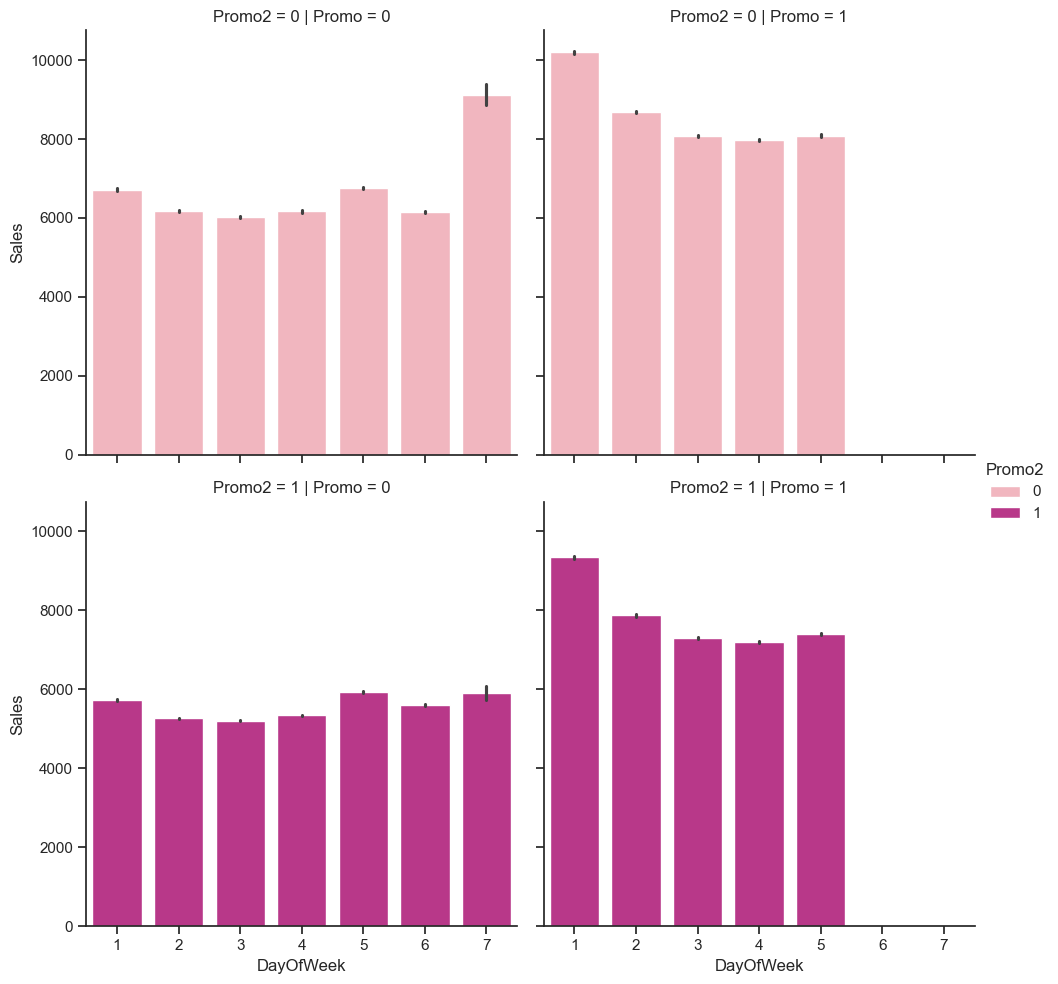

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_store' is your DataFrame and it includes the relevant columns
# Example setup for 'train_store' DataFrame
# You can skip this part if your DataFrame 'train_store' is already defined
# data = {
#     'DayOfWeek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon'],
#     'Sales': [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500],
#     'Promo': [1, 0, 1, 0, 1, 0, 1, 0],
#     'Promo2': [1, 1, 0, 0, 1, 1, 0, 0]
# }
# train_store = pd.DataFrame(data)

# Plotting sales trends using catplot
sns.catplot(
    data=train_store, 
    x='DayOfWeek', 
    y='Sales', 
    col='Promo', 
    row='Promo2', 
    hue='Promo2', 
    palette='RdPu', 
    kind='bar'  # specify the kind of plot, here using 'bar' as an example
)

# Show plot
plt.show()

##### There are several things here:
- In case of no promotion, both `Promo` and `Promo2` are equal to 0, `Sales` tend to peak on Sunday (!). Though we should note that `StoreType` C doesn't work on Sundays. So it is mainly data from `StoreType` A, B and D.
- On the contrary, stores that run the promotion tend to make most of the `Sales` on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (`Promo` and `Promo2` are equal to 1).
- `Promo2` alone doesn't seem to be correlated to any significant change in the `Sales` amount. This can be also prooved by the blue pale area on the heatmap above.

---

### Conclusion of EDA

- The most selling and crowded `StoreType` is A.


- The best "Sale per Customer" `StoreType` D indicates to the higher Buyer Cart. To benefit from this fact, Rossmann can consider proposing bigger variety of its products.


- Low `SalePerCustomer` amount for `StoreType` B indicates to the possible fact that people shop there essentially for "small" things. Eventhough this `StoreType` generated the least amount of sales and customers over the whole period, it shows a great potential.


- Customers tends to buy more on Modays when there's one promotion (`Promo`) and on Sundays when there's no promotion at all (both `Promo` and `Promo1` are equal to 0).


- Promo2 alone doesn't seem to be correlated to any significant change in the `Sales` amount.

<br>
## Time-Series Analysis per Store Type

What makes a time series different from a regular regression problem? 

- It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.
- Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

We build a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonalities in the dataset. 

In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.

### Seasonality

##### We take four stores from store types to represent their group:
- Store number 2 for `StoreType` A
- Store number 85 for `StoreType` B, 
- Store number 1 for `StoreType` C 
- Store number 13 for `StoreType` D. 

It also makes sense to downsample the data from days to weeks using the `resample` method to see the present trends more clearly.

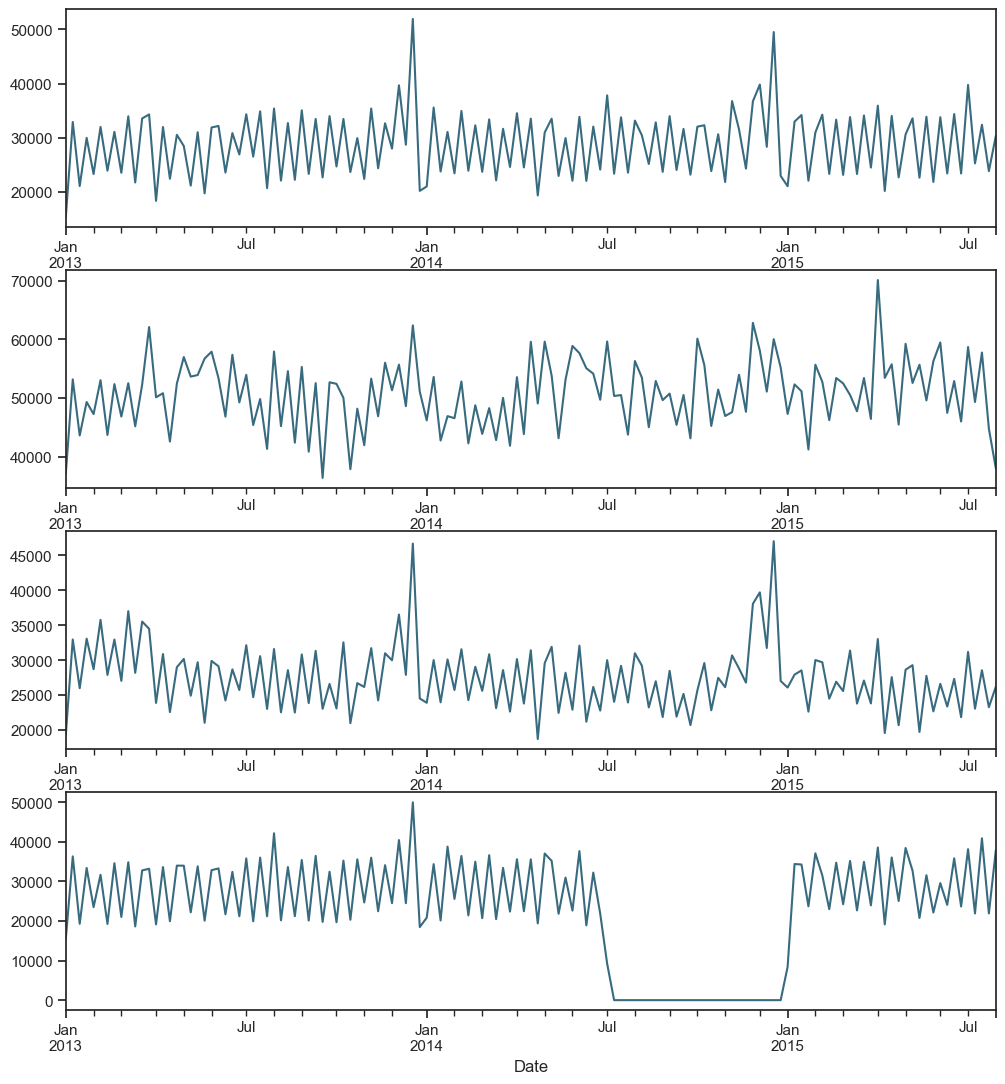

In [47]:
import matplotlib.pyplot as plt

# Define default color
c = '#386B7F'  # You can change this to any desired color

# Convert 'Sales' column to float type
train['Sales'] = train['Sales'].astype(float)

# Define store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending=True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

# Create subplots
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))

# Plot sales for each store type resampled by week and summed
sales_a.resample('W').sum().plot(color=c, ax=ax1)
sales_b.resample('W').sum().plot(color=c, ax=ax2)
sales_c.resample('W').sum().plot(color=c, ax=ax3)
sales_d.resample('W').sum().plot(color=c, ax=ax4)

# Display the plots
plt.show()

Retail sales for `StoreType` A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for `StoreType` D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.

### Yearly trend

The next thing to check the presence of a trend in series.

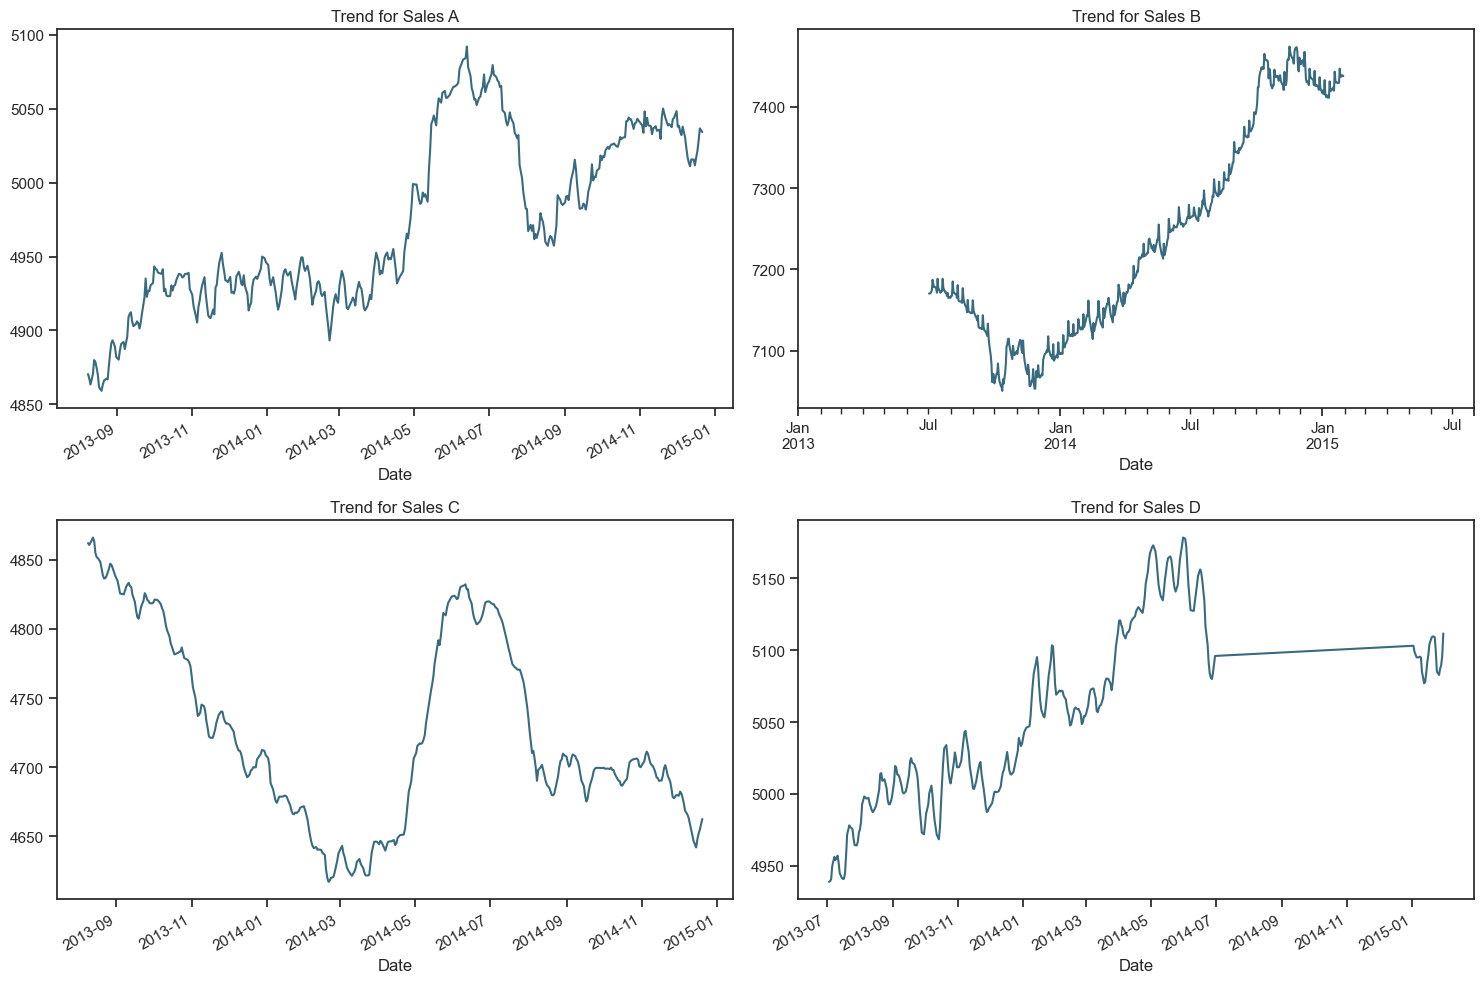

In [52]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Define default color
c = '#386B7F'  # You can change this to any desired color

# Define store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending=True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

# Create subplots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot seasonal decomposition for each store type
decomposition_a = seasonal_decompose(sales_a, model='additive', period=365)
decomposition_a.trend.plot(color=c, ax=ax1)
ax1.set_title('Trend for Sales A')

decomposition_b = seasonal_decompose(sales_b, model='additive', period=365)
decomposition_b.trend.plot(color=c, ax=ax2)
ax2.set_title('Trend for Sales B')

# Adjust the period parameter for sales_c and sales_d
decomposition_c = seasonal_decompose(sales_c, model='additive', period=365)
decomposition_c.trend.plot(color=c, ax=ax3)
ax3.set_title('Trend for Sales C')

# Adjusting the period for seasonal decomposition
decomposition_d = seasonal_decompose(sales_d, model='additive', period=300)  # Adjust the period here
decomposition_d.trend.plot(color=c, ax=ax4)
ax4.set_title('Trend for Sales D')

# Display the plots
plt.tight_layout()
plt.show()

Overall sales seems to increase, however not for the `StoreType` C (a third from the top). Eventhough the `StoreType` A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as `StoreType` C did.

### Autocorrelaion

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. 

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. 

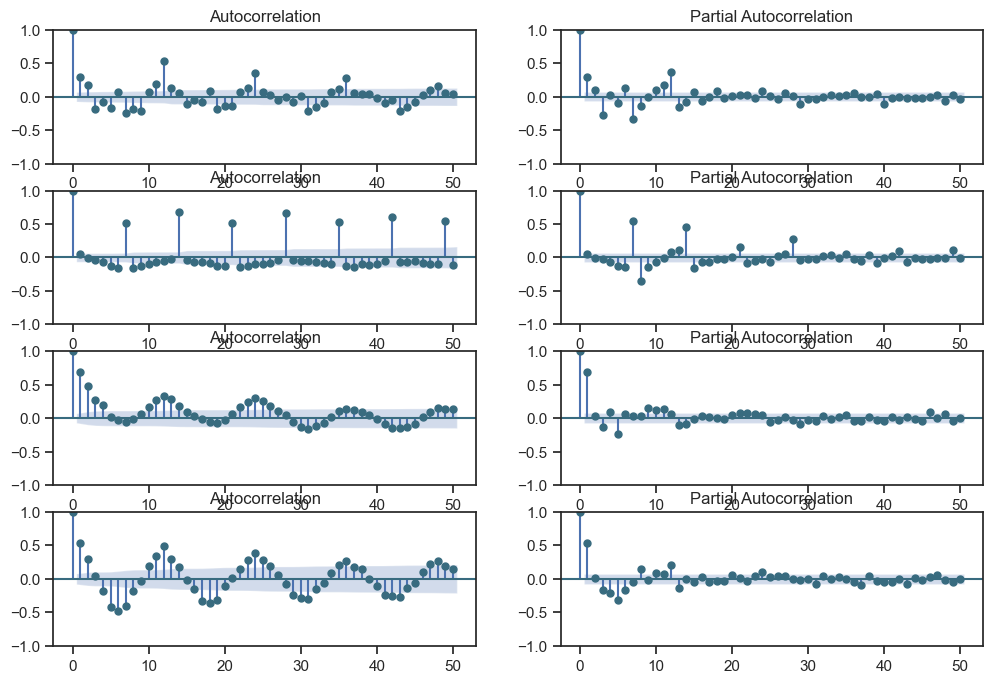

In [53]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

- Type A and type B:
Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags. 


- Type C and type D:
Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations. 

## Time Series Analysis and Forecasting with Prophet
#### Forecasting for the next 6 weeks for the first store

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called [Prophet](https://research.fb.com/prophet-forecasting-at-scale/). It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing [automated forecasting which are already implemented in R](https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima) at scale in Python 3.

In [55]:
# importing data
df = pd.read_csv("../data/raw/train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [56]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


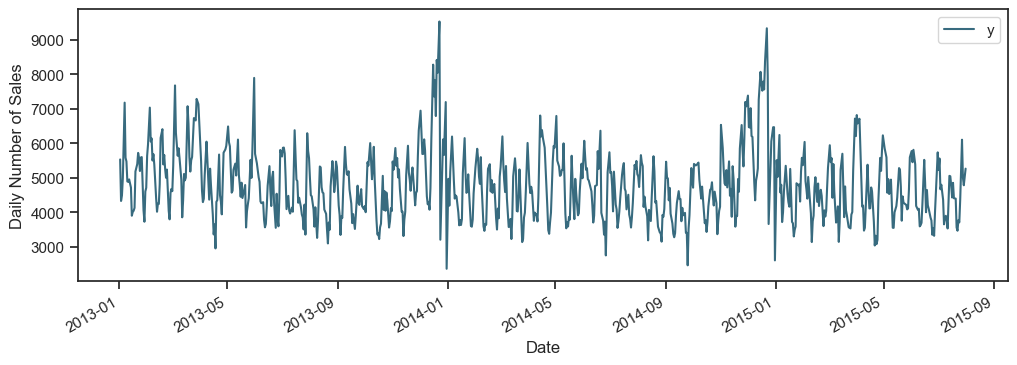

In [57]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### Modeling Holidays

Prophet also allows to [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html), and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.

In [58]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


### Conclusion of Time Series forecasting

During this part, we discussed time series analysis with `.seasonal_decompose()`, `ACF` and `PCF` plots.

We can now present main advantages and drawbacks of time series forecasting:

##### __Advantages__
- A powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manually).
- Easily implemented with R `auto.arima()` from `forecast` package, which runs a complex grid search and sophisticated algorithm behind the scene.

##### __Drawbacks__
- Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are `Promo` and `CompetitionOpen`. 
- Even though Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the biggest drawback for new companies.
- Seasonal ARIMA in Python has 7 hyper parameters which can be tuned only manually affecting significantly the speed of the forecasting process.